# Modellauswertungen

In [1]:
# Load Relevant Libraries, the model and the test data
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.models import model_from_json
import joblib
import pickle
import os
from tabulate import tabulate
import seaborn as sns
from modules.sequence_and_normalize import sequence_data, sequence_sample_random, sequence_list
from sklearn.preprocessing import MinMaxScaler
from modules.plots import plot_seq_i_d_Q
from modules.save_load_model import load_model, load_model_container
from modules.predict_and_prepare import pred_inverse_all, pred_and_add_durIndex, pred_all_list
from modules.eval_helpers import rmse_from_raw, mae_from_raw, mae_mse_rmse
from IPython.display import display, Markdown, Latex

2024-05-03 22:24:34.296641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-05-03 22:24:35.095155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Notebook parameters
model_names = ['Gievenbeck_LSTM_Single_MSE2024-05-03', 'Gievenbeck_LSTM_Single_MSE_No_Shuffle_2024-05-03']
model_alias = ['"Shuffle = True"','"Shuffle = False"']
base_folder = os.path.join('05_models', 'shuffle_compare')
model_names = ['Gievenbeck_LSTM_Single_MSE_Shuffle_u32_2024-05-03']
model_alias = ['"Units = 32"']
base_folder = os.path.join('05_models', 'units_compare')

In [3]:
# Parameters
model_names = ["Gievenbeck_LSTM_Single_MSE_u128_2024-05-03", "Gievenbeck_LSTM_Double_MSE_u128_2024-05-03", "Gievenbeck_LSTM_Triple_MSE_u128_2024-05-03"]
model_alias = ["\"1 Schicht\"", "\"2 Schichten\"", "\"3 Schichten\""]
base_folder = "05_models/deep_compare"


In [4]:

# Get Model and Data
models = []
for model_name in model_names:
    model_folder = os.path.join(base_folder, model_name)
    model_container = load_model_container(model_folder, print_info=False)
    model_id = 'model_' + str(model_container['select_id'])
    # model = model_container[model_id]
    model = model_container['selected_model']
    model['cv_scores'] = model_container['cv_scores']
    comb_history = {}
    for key in model_container['selected_model']['history'].keys():
        sel_history = model_container['selected_model']['history'][key]
        prev_history = model_container[model_id]['history'][key]
        comb_history[key] = prev_history + sel_history
    model['combined_history'] = comb_history

    models.append(model)

out_unit = 'm³/s'

metrics_labels = { 'mape': 'Mittlerer absoluter prozentualer Fehler - MAPE [%]',
                  'mae': 'Mittlerer absoluter Fehler - MAE [' + out_unit + ']', 
                  'rmse': 'Wurzel der mittleren Fehlerquadratsumme - RMSE [' + out_unit + ']',
                   'mse': 'Mittlere Fehlerquadratsumme - MSE [-]',}



2024-05-03 22:24:36.126493: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:24:36.153173: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:24:36.153242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:24:36.156119: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:24:36.156190: I external/local_xla/xla/stream_executor

/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:24:36.445735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:24:36.445842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 22:24:36.445851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2019] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-05-03 22:24:36.445918: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000

/home/fl-al/miniconda3/envs/ml/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


/home/fl-al/miniconda3/envs/ml/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [5]:
# Check if test_data is same
sum_check = []
for m in models:
    sum_m = 0
    for event in m['train_data']:
        sum_m = sum_m + sum(event[1]['duration'])

    sum_check.append(sum_m)

test_same = all(x == sum_check[0] for x in sum_check)


In [6]:
# Predict and prepare all data for all given models

for m in models:
    model = m['model']
    lag = m['lag']
    delay = m['delay']
    p_steps = m['prediction_steps']
    in_vars = m['in_vars']
    out_vars = m['out_vars']
    if test_same == True:
        test_data = m['test_data']
    else:
        test_data = models[1]['test_data']
    train_data = m['train_data']
    # val_data = m['validation_data']
    in_scaler = m['in_scaler']
    out_scaler = m['out_scaler']

    seq_train, seq_train_trans = sequence_list(train_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)
    
    # seq_val, seq_val_trans = sequence_list(val_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    # out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)
    
    seq_test, seq_test_trans = sequence_list(test_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)

    # Strukture:    pred_list[event_id][data_id][sequence_id] where data_id = 0 is event meta data, 
    #               data_id = 1 is input data, data_id = 2 is true data and data_id = 3 is predicted data
    test_pred_list = pred_and_add_durIndex(model, out_scaler, seq_test, seq_test_trans)

    train_true, train_pred = pred_inverse_all(train_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    # val_true, val_pred = pred_inverse_all(val_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    test_true, test_pred = pred_inverse_all(test_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    
    train_resid = train_true - train_pred
    # val_resid = val_true - val_pred
    test_resid = test_true - test_pred
    train_resid = train_resid.flatten()
    # val_resid = val_resid.flatten()
    test_resid = test_resid.flatten()

    train_eval = mae_mse_rmse(train_true, train_pred)
    # val_eval = mae_mse_rmse(val_true, val_pred)
    test_eval = mae_mse_rmse(test_true, test_pred)
    
    m.update({'seq_test':seq_test, 'seq_test_trans':seq_test_trans,
                    'seq_train':seq_train, 'seq_train_trans':seq_train_trans,
                    # 'seq_val':seq_val, 'seq_val_trans':seq_val_trans,
                    'train_true':train_true, 'train_pred':train_pred, 
                    # 'val_true':val_true, 'val_pred':val_pred, 
                    'test_true':test_true, 'test_pred':test_pred,
                    'train_resid':train_resid, 'test_resid':test_resid,
                    # 'val_resid':val_resid, 'val_eval':val_eval, 
                    'train_eval':train_eval, 'test_eval':test_eval, 
                    'test_pred_list': test_pred_list,'print_name':model_alias[models.index(m)]})

I0000 00:00:1714767881.270636  148394 service.cc:145] XLA service 0xa4c0a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714767881.270677  148394 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6


2024-05-03 22:24:41.512683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2024-05-03 22:24:42.290873: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8904


I0000 00:00:1714767883.120042  148394 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
# out_scaler = models[0]['out_scaler']
# model = models[0]['model']
# in_vars = models[0]['in_vars']
# out_vars = models[0]['out_vars']
# in_scaler = models[0]['in_scaler']
# out_scaler = models[0]['out_scaler']
# lag = models[0]['lag']
# delay = models[0]['delay']
# p_steps = models[0]['prediction_steps']
# test_data = models[0]['test_data']
# pred_list = pred_all_list(model, out_scaler, seq_test, seq_test_trans)
# pred_list2 = pred_and_add_durIndex(model, out_scaler, seq_test, seq_test_trans)
# true3,  pred_list3 = pred_inverse_all([test_data[0]], model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)


In [8]:
# pred_list = models[0]['test_pred_list']
# print(pred_list[0][3][10])
# print(pred_list2[0][3][10])
# print(pred_list3[10])

In [9]:
# Print all Event meta data 
# i=0
# for obj in seq_test_trans:
#     print(i, obj[0])
#     i += 1


In [10]:
#Print model summary
display(Markdown("## **Modellzusammenfassungen** "))
for m in models:
    text = "### **" + m['name'] + "**"
    display(Markdown(text))
    try:
        total_train_time = m['total_train_time']
    except:
        total_train_time = 'N/A'
        pass
    head = f"**Alias: {m['print_name']}**<br><br>Gesamte Trainingszeit: {total_train_time}"
    display(Markdown(head))
    opti = m['model'].optimizer.get_config()
    print("Optimierungsmethode: ", opti['name'])
    print("Verlustfunktion: ", m['model'].loss)
    model_sum = m['model'].summary()
    print(tabulate(model_sum))
    print("______________________________________________________________________________________________\n\n")

## **Modellzusammenfassungen** 

### **Gievenbeck_LSTM_Single_MSE_u128_2024-05-03**

**Alias: "1 Schicht"**<br><br>Gesamte Trainingszeit: 1145.8779051303864

Optimierungsmethode:  adam
Verlustfunktion:  mse


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Q1 (Dense)                      │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,862 (804.15 KB)

 Trainable params: 68,620 (268.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,242 (536.11 KB)


______________________________________________________________________________________________




### **Gievenbeck_LSTM_Double_MSE_u128_2024-05-03**

**Alias: "2 Schichten"**<br><br>Gesamte Trainingszeit: 1910.5469925403595

Optimierungsmethode:  adam
Verlustfunktion:  mse


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Q1 (Dense)                      │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 600,614 (2.29 MB)

 Trainable params: 200,204 (782.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 400,410 (1.53 MB)


______________________________________________________________________________________________




### **Gievenbeck_LSTM_Triple_MSE_u128_2024-05-03**

**Alias: "3 Schichten"**<br><br>Gesamte Trainingszeit: 2686.4283168315887

Optimierungsmethode:  adam
Verlustfunktion:  mse


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Q1 (Dense)                      │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 995,366 (3.80 MB)

 Trainable params: 331,788 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 663,578 (2.53 MB)


______________________________________________________________________________________________




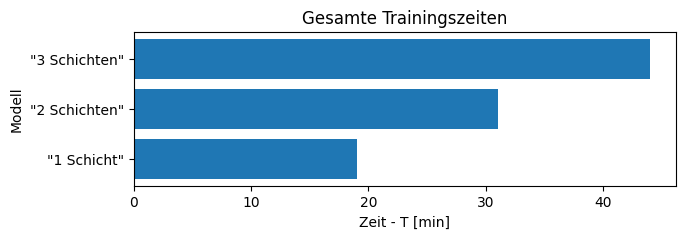

In [11]:
# Train times
import random
times = pd.DataFrame(columns=['Model', 'Train Time'])
for m in models:
    try:
        total_train_time = round(int(m['total_train_time']) // 60, 0)
    except:
        total_train_time = 'N/A'
        pass
    new_row = pd.DataFrame([{'Model': m['print_name'], 'Train Time': total_train_time }])
    times = pd.concat([times,new_row], ignore_index=True)

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 2))
plt.barh(times['Model'], times['Train Time'])

# Add labels and title
plt.xlabel('Zeit - T [min]')
plt.ylabel('Modell')
plt.title('Gesamte Trainingszeiten')

# Display the plot
plt.show()

### Datenaufteilung

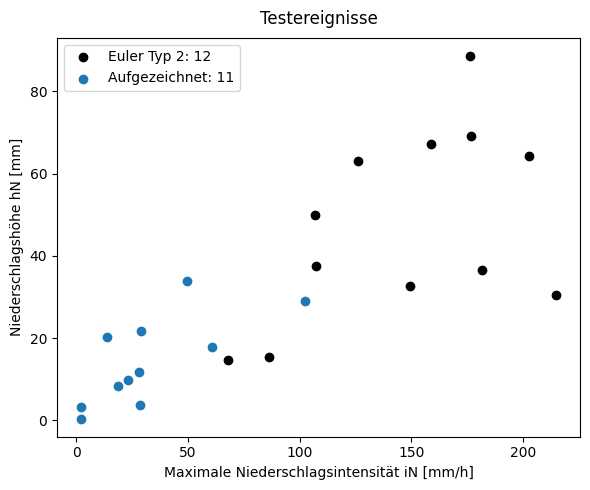

In [12]:
# Extract total precipitation and max intensity from seq_test
seq_test_trans = models[0]['seq_test_trans']
e2_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']
e2_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']

aufgezeichnet_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']
aufgezeichnet_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.plot( e2_intensity, e2_precipitation,'o', color='black', label='Sample')
ax2.scatter(aufgezeichnet_intensity, aufgezeichnet_precipitation, marker='o',  label='Events')
ax2.set_xlabel('Maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Testereignisse', pad=10)
ax2.legend(labels=['Euler Typ 2: {}'.format(len(e2_precipitation)), 'Aufgezeichnet: {}'.format(len(aufgezeichnet_precipitation))])
plt.tight_layout()


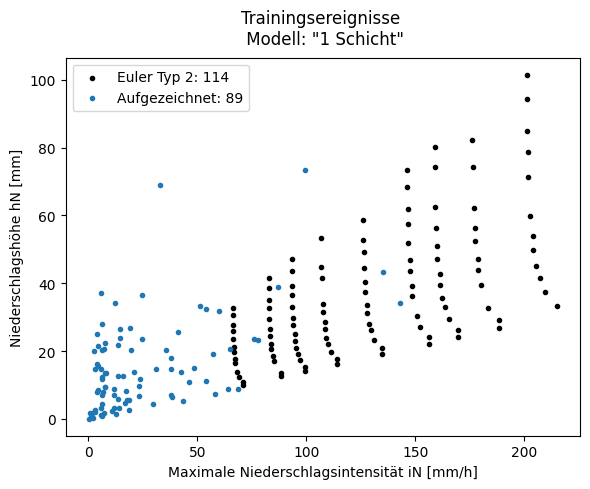

In [13]:
m = models[0]
train_e2_precip = [obj[0]['total precipitation'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Euler Typ 2']
train_e2_intensity = [obj[0]['max intensity'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Euler Typ 2']

train_measured_precip = [obj[0]['total precipitation'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Aufgezeichnet']
train_measured_intensity = [obj[0]['max intensity'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Aufgezeichnet']

# val_e2_precip = [obj[0]['total precipitation'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Euler Typ 2']
# val_e2_intensity = [obj[0]['max intensity'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Euler Typ 2']

# val_measured_precip = [obj[0]['total precipitation'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Aufgezeichnet']
# val_measured_intensity = [obj[0]['max intensity'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Aufgezeichnet']

train_precip = [obj[0]['total precipitation'] for obj in seq_train_trans]
train_intensity = [obj[0]['max intensity'] for obj in seq_train_trans]

# val_precip = [obj[0]['total precipitation'] for obj in seq_val_trans]
# val_intensity = [obj[0]['max intensity'] for obj in seq_val_trans]

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.scatter(train_e2_intensity, train_e2_precip, marker='.', color='black', label='Sample')
ax2.scatter(train_measured_intensity, train_measured_precip, marker='.', label='Events')
# ax2.plot( val_e2_intensity, val_e2_precip,'o', color='Black', label='Sample')
# ax2.scatter(val_measured_precip, val_measured_intensity, marker='x', color='Black', label='Events')

ax2.set_xlabel('Maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Trainingsereignisse \n Modell: ' + m['print_name'], pad=10)
# ax2.legend(labels=['Training (Euler Typ 2): {}'.format(len(train_e2_intensity)), 'Training (Aufgezeichnet): {}'.format(len(train_measured_precip)), 
#                 'Validierung (Euler Typ 2): {}'.format(len(val_e2_precip)), 'Validierung (Aufgezeichnet): {}'.format(len(val_measured_intensity))])
ax2.legend(labels=['Euler Typ 2: {}'.format(len(train_e2_intensity)), 'Aufgezeichnet: {}'.format(len(train_measured_precip))])
plt.tight_layout()

### Gesamtergebnisse der Modelle

**Auswertung des durchschnittlichen Metriken der Kreuzvalidierung**

Bei jeder Modellerstellung werden die Daten zufällig in Trainings- und Validierungsdaten aufgeteilt. Die Balken zeigen die durchschnittlichen Metriken der Kreuzvalidierung für die Trainings- und Validierungsdaten.

Hierbei ist zu beachten, dass diese Metrik vor der Datentransformation berechnet wurde und somit nur in diesem Verlgleich aussagekraft habe und mit nachfolgenden Metriken nicht vergleichbar ist.

Durchschnittlicher MSE:

+---------------+----------+-------------+
|    Modell     | Training | Validierung |
+---------------+----------+-------------+
|  "1 Schicht"  | 0.00037  |   0.00035   |
| "2 Schichten" | 0.00035  |   0.00049   |
| "3 Schichten" | 0.00021  |   0.00026   |
| "3 Schichten" | 0.00021  |   0.00026   |
+---------------+----------+-------------+


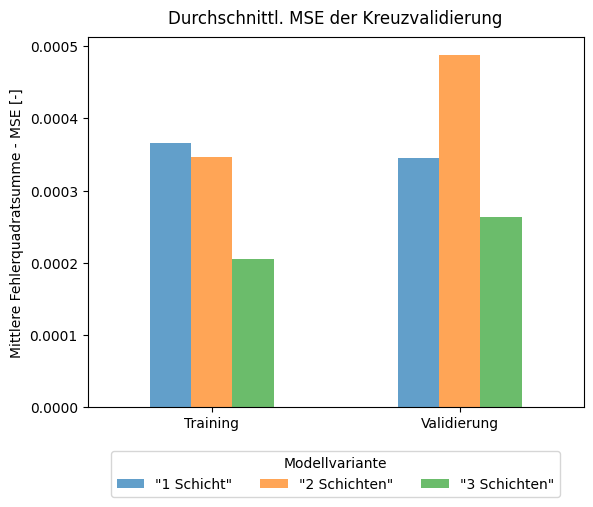

Durchschnittlicher MAE:

+---------------+----------+-------------+
|    Modell     | Training | Validierung |
+---------------+----------+-------------+
|  "1 Schicht"  | 0.00037  |   0.00035   |
| "2 Schichten" | 0.00035  |   0.00049   |
| "3 Schichten" | 0.00021  |   0.00026   |
| "3 Schichten" | 0.00021  |   0.00026   |
+---------------+----------+-------------+


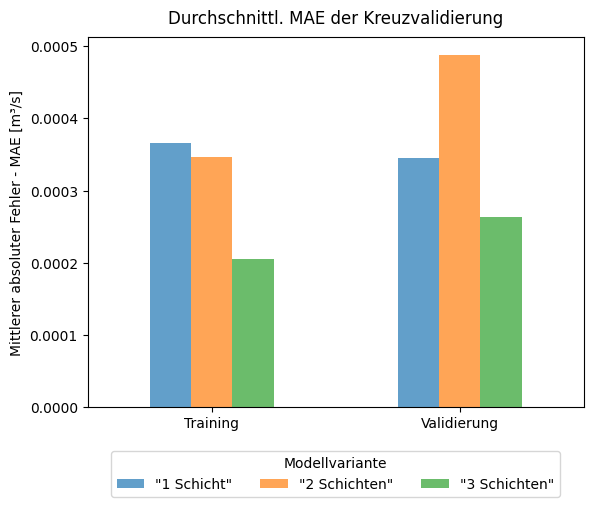

In [14]:
# cross validation results
display(Markdown('**Auswertung des durchschnittlichen Metriken der Kreuzvalidierung**'))
display(Markdown('Bei jeder Modellerstellung werden die Daten zufällig in Trainings- und Validierungsdaten aufgeteilt. Die Balken zeigen die durchschnittlichen Metriken der Kreuzvalidierung für die Trainings- und Validierungsdaten.'))
display(Markdown('Hierbei ist zu beachten, dass diese Metrik vor der Datentransformation berechnet wurde und somit nur in diesem Verlgleich aussagekraft habe und mit nachfolgenden Metriken nicht vergleichbar ist.'))


metrics = ['mse', 'mae']

for metric_name in metrics:
    metric = pd.DataFrame()
    metric_table = pd.DataFrame()
    metric_upper = metric_name.upper()
    for m in models:
        name = m['print_name']
        train_result = m['cv_scores']['loss'].mean()
        val_result = m['cv_scores']['val_loss'].mean()
        if val_result < 1 or train_result < 1:
            new_row = pd.DataFrame({'Modell':name,'Training': train_result, 'Validierung': val_result}, index=[0])
            metric = pd.concat([metric, pd.DataFrame(new_row)] , ignore_index=True)
            metric_table = pd.concat([metric, pd.DataFrame(new_row)] , ignore_index=True)
        else:
            new_row = pd.DataFrame({'Modell':name,'Training': train_result, 'Validierung': val_result}, index=[0])
            metric_table = pd.concat([metric, pd.DataFrame(new_row)] , ignore_index=True)

    ax = metric.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=False)
    ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, title='Modellvariante')
    ax.set_ylabel(metrics_labels[metric_name])

    ax.set_title('Durchschnittl. '+ metric_upper + ' der Kreuzvalidierung', pad=10)
    display(Markdown('Durchschnittlicher ' + metric_upper + ':'))
    print(tabulate(round(metric_table, 5), headers='keys', tablefmt='pretty', showindex=False))
    # Show the plot
    plt.show()

## **Lernkurven**

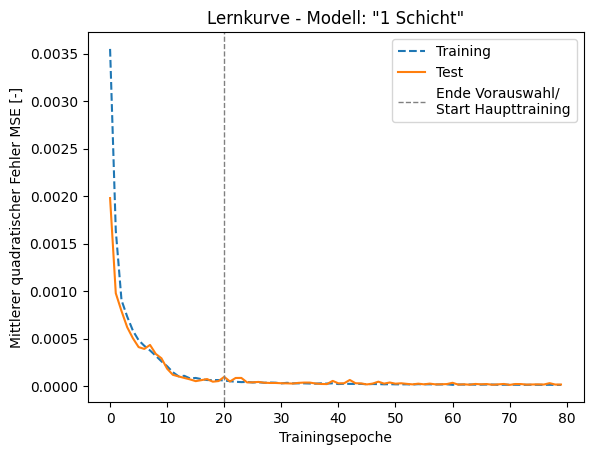

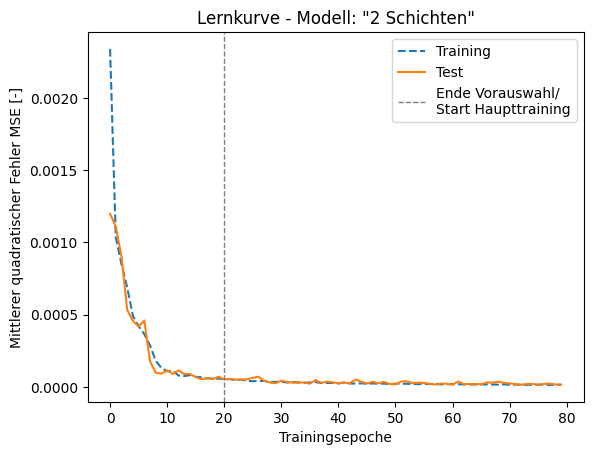

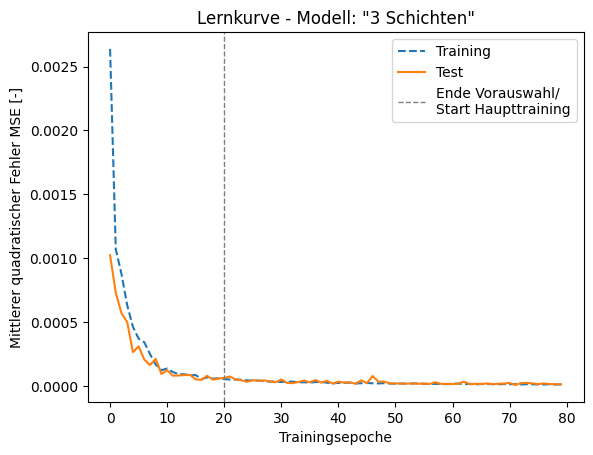

In [15]:
# Plot the learning curve
display(Markdown('## **Lernkurven**'))
metrics = ['mse', 'mae']
for m in models:
    metric = 'mse'
    train_switch = len(m['combined_history'][metric]) - len(m['history'][metric])
    pyplot.plot(m['combined_history']['mse'], '--', label='Training')
    if 'val_'+metric in m['combined_history']:
        pyplot.plot(m['combined_history']['val_'+metric], label='Test')
    pyplot.axvline(x=train_switch, color='grey', linestyle='--', linewidth=1, label='Ende Vorauswahl/\nStart Haupttraining')
    pyplot.xlabel('Trainingsepoche')
    pyplot.ylabel('Mittlerer quadratischer Fehler MSE [-]')
    pyplot.legend()
    pyplot.title('Lernkurve - Modell: ' + m['print_name'])
    pyplot.show()

**Auswertung nach RMSE**

+---------------+----------+--------+
|    Modell     | Training |  Test  |
+---------------+----------+--------+
|  "1 Schicht"  |  0.0084  |  0.01  |
| "2 Schichten" |  0.0077  | 0.0095 |
| "3 Schichten" |  0.0075  | 0.0094 |
+---------------+----------+--------+


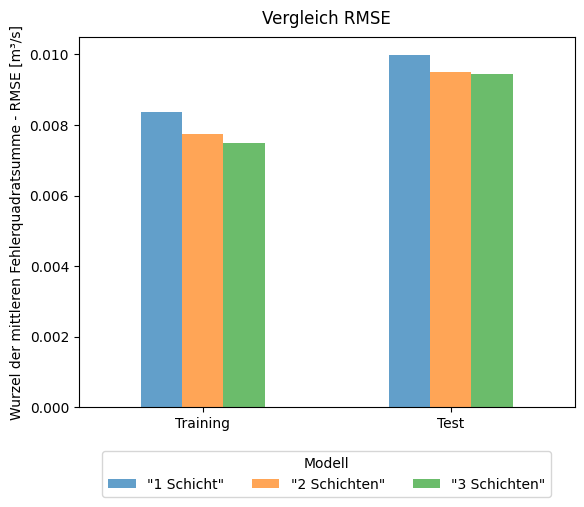

**Auswertung nach MAE**

+---------------+----------+--------+
|    Modell     | Training |  Test  |
+---------------+----------+--------+
|  "1 Schicht"  |  0.0036  | 0.0045 |
| "2 Schichten" |  0.003   | 0.0038 |
| "3 Schichten" |  0.003   | 0.0042 |
+---------------+----------+--------+


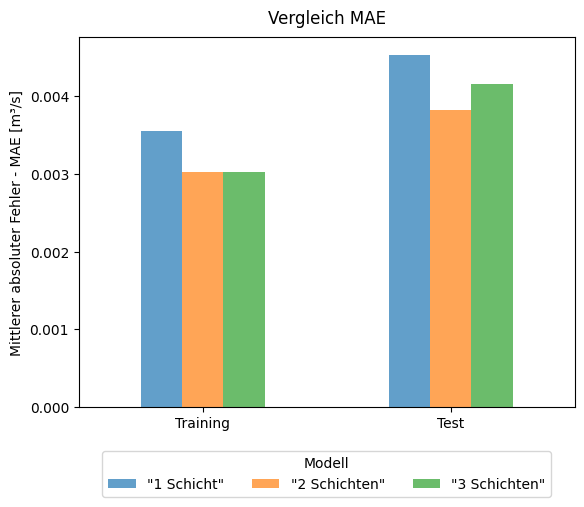

In [16]:
# Vergleich RMSE
metric_names = ('rmse', 'mae')
for m_name in metric_names:
    metrics = pd.DataFrame()
    name_upper = m_name.upper()
    for m in models:
        name = m['print_name']
        train_metric = m['train_eval'][m_name]
        # val_metric = m['val_eval'][m_name]
        test_metric = m['test_eval'][m_name]
        new_row = pd.DataFrame({'Modell':name,'Training': train_metric, 'Test': test_metric}, index=[0])
        # new_row = pd.DataFrame({'Modell':name,'Training': train_metric, 'Validierung': val_metric, 'Test': test_metric}, index=[0])
        metrics = pd.concat([metrics, pd.DataFrame(new_row)] , ignore_index=True)

    ax = metrics.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=False)
    ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, title='Modell')
    ax.set_ylabel(metrics_labels[m_name])

    ax.set_title('Vergleich ' + name_upper, pad=10)

    # print(name_upper)
    display(Markdown('**Auswertung nach '+name_upper+'**'))
    print(tabulate(round(metrics, 4), headers='keys', tablefmt='pretty', showindex=False))

    # Show the plot
    plt.show()

### Modellauswertung nach Größenklassen der Ausgabewerte

In [17]:
import warnings
# Metrics based on Output magnitude
magnitude_metrics = []

for m in models:

    test_true_flattened = m['test_true'].flatten()
    test_pred_flattened = m['test_pred'].flatten()

    test_stack_flat = np.column_stack((test_true_flattened, test_pred_flattened))
    test_stack_flat = test_stack_flat[test_stack_flat[:, 0] != 0]
    test_stack_flat = pd.DataFrame(test_stack_flat, columns=['True', 'Pred'])

    # Get the value range of test_stack['True']
    value_range = np.ptp(test_stack_flat['True'])

    # Split the value range into 4 equal ranges
    ranges = np.linspace(0, np.max(test_stack_flat['True']), num=11)


    test_stack_flat['Bins'] = pd.cut(test_stack_flat['True'], bins=ranges, labels=False, include_lowest=True)
    ranges = np.round(ranges, 2)

    # Get unique bins
    unique_bins = test_stack_flat['Bins'].unique()
    unique_bins = sorted(unique_bins)



    # Create a list to store the datasets
    bins = []

    # Iterate over each unique bin
    for bin_num in unique_bins:
        # Filter the dataframe for the current bin
        bin_data = test_stack_flat[test_stack_flat['Bins'] == bin_num].copy()
        
        # Append the filtered dataset to the list
        bins.append(bin_data)

    metrics = pd.DataFrame([])
    metrics = pd.DataFrame(columns=['Bin', 'MSE','RMSE', 'MAE', 'MAPE', 'start', 'end', 'False_0', 'n'])
    i = 0
    for bin in bins:
        mse = np.mean((bin['True'] - bin['Pred'])**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(bin['True'] - bin['Pred']))
        mape = np.mean(np.abs((bin['True'] - bin['Pred']) / bin['True'])) * 100
        
        bin_start = ranges[i]
        bin_end = ranges[i+1]
        False_0 = len(bin[bin['Pred'] == 0])
        n = len(bin)

        new_row = pd.DataFrame({'Bin':i, 'MSE':mse,'RMSE':rmse, 'MAE':mae, 'MAPE':mape, 'start':bin_start, 'end':bin_end, 'False_0': False_0, 'n':n}, index=[0])

        i +=1
        
        metrics = pd.concat([metrics,new_row], ignore_index=True)
        
    
    magnitude_metrics.append(metrics)



i = 0
for metric in magnitude_metrics:
    metric[['MSE', 'MAE', 'RMSE']] = metric[['MSE', 'MAE', 'RMSE']].round(4)
    metric[['MAPE']] = metric[['MAPE']].round(2)
    print('Modell: ' + models[i]['print_name'])
    print(tabulate(metric, headers='keys', tablefmt='pretty', showindex=False))
    i += 1

warnings.filterwarnings("ignore")


Modell: "1 Schicht"
+-----+--------+--------+--------+-------+-------+------+---------+------+
| Bin |  MSE   |  RMSE  |  MAE   | MAPE  | start | end  | False_0 |  n   |
+-----+--------+--------+--------+-------+-------+------+---------+------+
|  0  | 0.0001 | 0.0097 | 0.0067 | 11.77 |  0.0  | 0.24 |   42    | 8715 |
|  1  | 0.0004 | 0.0194 | 0.0146 | 4.48  | 0.24  | 0.49 |    0    | 519  |
|  2  | 0.0012 | 0.0343 | 0.0248 | 4.12  | 0.49  | 0.73 |    0    | 184  |
|  3  | 0.0015 | 0.0388 | 0.0273 | 3.31  | 0.73  | 0.97 |    0    |  85  |
|  4  | 0.0013 | 0.0361 | 0.0281 | 2.53  | 0.97  | 1.22 |    0    | 107  |
|  5  | 0.0013 | 0.0366 | 0.031  | 2.38  | 1.22  | 1.46 |    0    |  43  |
|  6  | 0.002  | 0.0442 | 0.0344 | 2.25  | 1.46  | 1.7  |    0    |  26  |
|  7  | 0.001  | 0.0309 | 0.0252 |  1.4  |  1.7  | 1.95 |    0    |  54  |
|  8  | 0.0017 | 0.0416 | 0.0353 | 1.71  | 1.95  | 2.19 |    0    |  63  |
|  9  | 0.0013 | 0.0363 | 0.0296 | 1.29  | 2.19  | 2.43 |    0    |  79  |
+----

/tmp/ipykernel_148271/4241526601.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics,new_row], ignore_index=True)
/tmp/ipykernel_148271/4241526601.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics,new_row], ignore_index=True)
/tmp/ipykernel_148271/4241526601.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns 

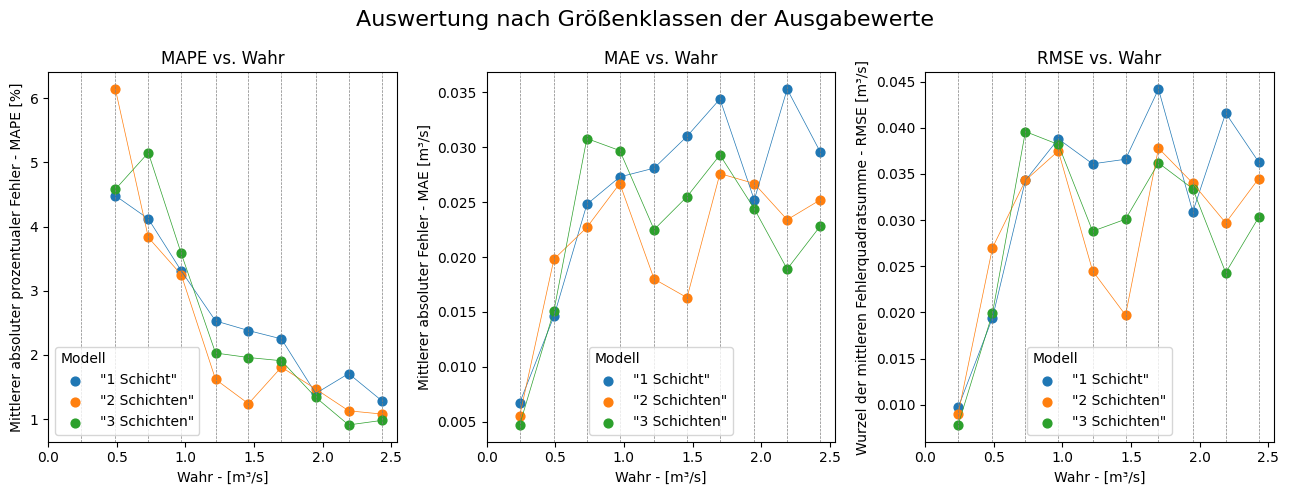

In [18]:
metrics = ('MAPE', 'MAE', 'RMSE')


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

j = 0
for metric in metrics:
    i = 0
    for m in magnitude_metrics:
        if metric == 'MAPE':
            x = m['end'].iloc[1:]
            y = m[metric].iloc[1:]
        else:
            x = m['end']
            y = m[metric]
        
        # print(m)
        axs[j].scatter(x, y, label = models[i]['print_name'], marker='o', s=40)
        axs[j].plot(x, y, linewidth=0.5)
        i += 1
    axs[j].set_xlabel('Wahr - ['+ out_unit + ']')
    axs[j].set_ylabel(metrics_labels[metric.lower()])
    for border in magnitude_metrics[0]['end']:
        axs[j].axvline(x=border, color = 'grey', linestyle='--', linewidth=0.5)
    axs[j].set_title(metric + ' vs. Wahr')
    axs[j].set_xlim(0,None)

    axs[j].legend(title="Modell", fancybox=True)._legend_box.align = "left"
    
    j += 1

fig.suptitle('Auswertung nach Größenklassen der Ausgabewerte', fontsize=16)
plt.tight_layout()
plt.show()

### Darstellung aller Vorhersagen und Residuen

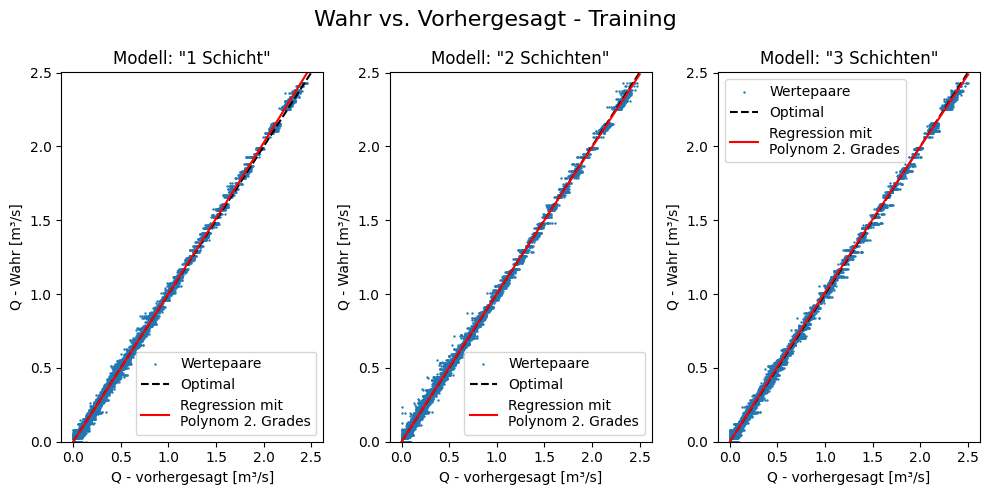

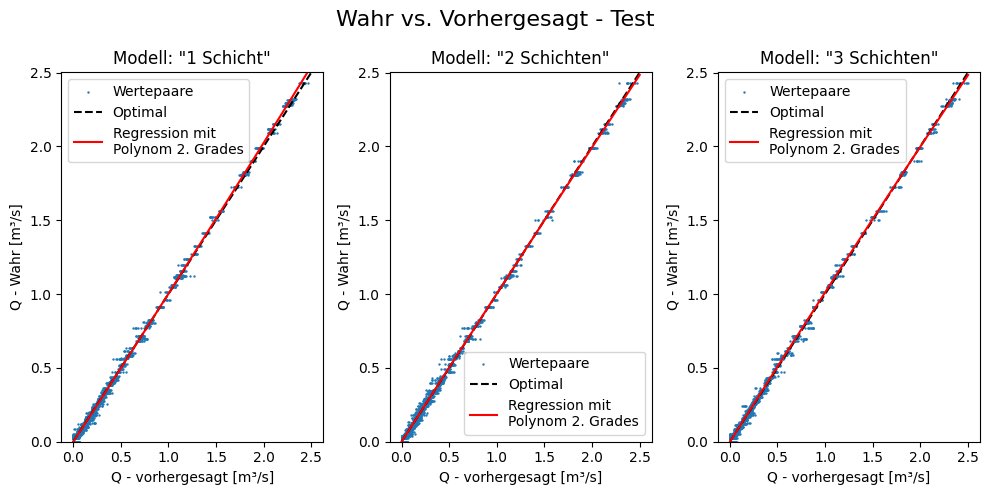

In [19]:
# Plot True vs. Predicted
cols = ['Modell: {}'.format(m_name['print_name']) for m_name in models]
rows = ['{}'.format(row) for row in ['Training', 'Test']]
# rows = ['{}'.format(row) for row in ['Training', 'Validierung', 'Test']]

m_trues = []
m_preds = []
mins =[]
maxs = []

for m in models:
    # Calculate the regression line using polynomial fit
    train_pred_flat = m['train_pred'].flatten()
    train_true_flat = m['train_true'].flatten()
    # val_pred_flat = m['val_pred'].flatten()
    # val_true_flat = m['val_true'].flatten()
    test_pred_flat = m['test_pred'].flatten()
    test_true_flat = m['test_true'].flatten()
    names = ['Training', 'Test']
    preds = [train_pred_flat, test_pred_flat]
    trues = [train_true_flat, test_true_flat]
    # names = ['Training', 'Validierung', 'Test']
    # preds = [train_pred_flat, val_pred_flat, test_pred_flat]
    # trues = [train_true_flat, val_true_flat, test_true_flat]
    min_value = min(min(r) for r in preds)
    max_value = max(max(r) for r in preds)
    mins.append(min_value)
    maxs.append(max_value)
    m_preds.append(preds)
    m_trues.append(trues)

min_val = min(mins)
max_val = max(maxs)
regression_range = np.linspace(min_val, max_val, 100)

# Plot if only one model is given
if len(m_preds) == 1:
    for j in range(len(m_preds)):
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

        for i in range(len(m_preds[j])):
            # Create a figure and subplots

            reg_line = np.polyfit(m_preds[j][i], m_trues[j][i], 2)
            reg_line_fn = np.poly1d(reg_line)
            # Plot train_pred/train_resid
            axs[i].scatter(m_preds[j][i], m_trues[j][i], marker ='.', s= 2, label = 'Wertepaare')
            axs[i].set_title(names[i])
            axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
            axs[i].set_ylabel('Q - Wahr ['+ out_unit + ']')    
            # Plot the average line
            axs[i].plot([0, max_val], [0, max_val], color='black', linestyle='--', label='Optimal')
            # Plot the regression line
            axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Regression mit\nPolynom 2. Grades')
            axs[i].legend(frameon=False)
            axs[i].set_ylim(min_val, max_val)
            axs[i].legend()

    fig.suptitle('Wahr vs. Vorhergesagt - ' + models[j]['print_name'], fontsize=16)
    plt.show()

# Plot if more than one model are given
else:
    for j in range(len(m_preds[0])):
        fig, axs = plt.subplots(ncols=len(models),figsize=(10, 5))

        for i in range(len(m_preds)):
            try:
                # Create a figure and subplots

                reg_line = np.polyfit(m_preds[i][j], m_trues[i][j], 2)
                reg_line_fn = np.poly1d(reg_line)
                # Plot train_pred/train_resid
                axs[i].scatter(m_preds[i][j], m_trues[i][j], marker ='.', s= 2, label = 'Wertepaare')
                axs[i].set_title(cols[i])
                axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
                axs[i].set_ylabel('Q - Wahr ['+ out_unit + ']')    
                # Plot the average line
                axs[i].plot([0, max_val], [0, max_val], color='black', linestyle='--', label='Optimal')
                # Plot the regression line
                axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Regression mit\nPolynom 2. Grades')
                axs[i].legend(frameon=False)
                axs[i].set_ylim(min_val, max_val)
                axs[i].legend()
            except:
                pass
        fig.suptitle('Wahr vs. Vorhergesagt - ' + rows[j], fontsize=16)
        fig.tight_layout()
        plt.show()

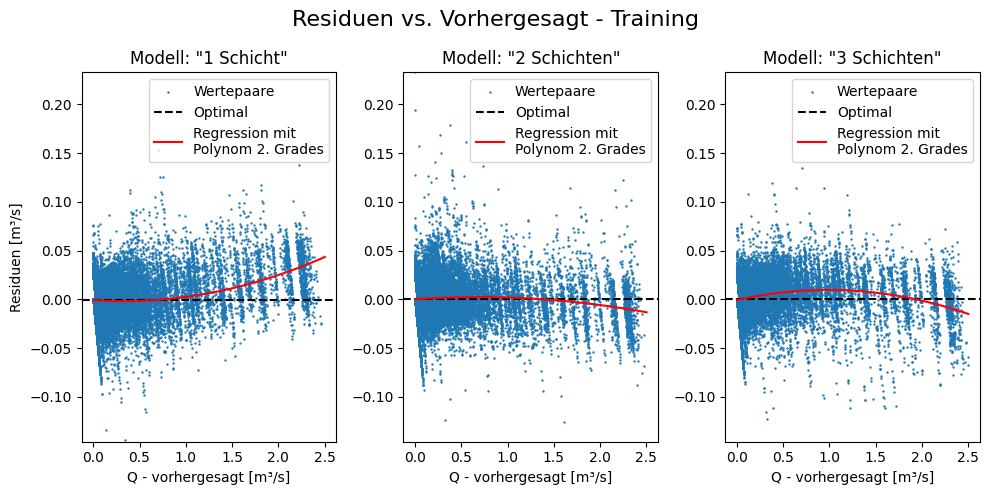

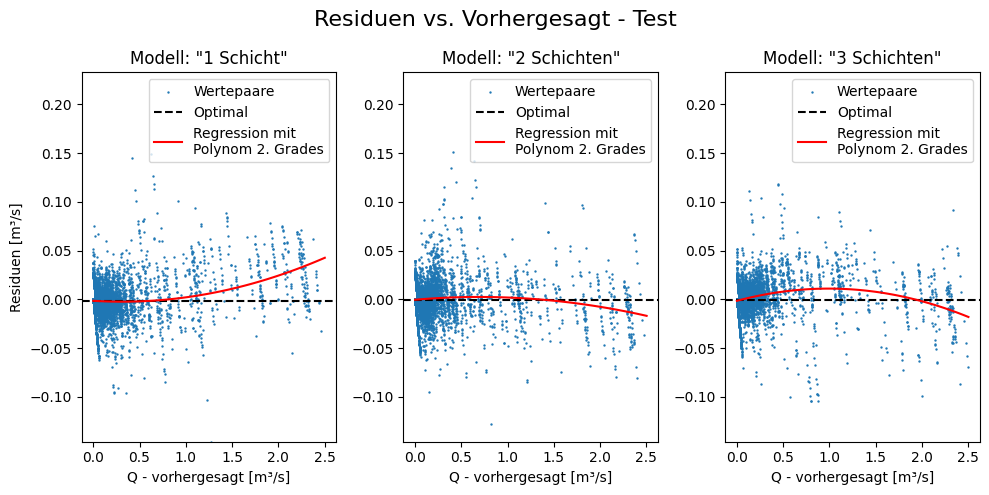

In [20]:
# Plot True vs. Predicted
# plt.rcParams['text.usetex'] = False

cols = ['Modell: {}'.format(m_name['print_name']) for m_name in models]
rows = ['{}'.format(row) for row in ['Training', 'Test']]
# rows = ['{}'.format(row) for row in ['Training', 'Validierung', 'Test']]

m_resids = []
m_preds = []
mins =[]
maxs = []
maxs_preds = []
for m in models:
    # Calculate the regression line using polynomial fit
    train_pred_flat = m['train_pred'].flatten()
    train_resid = m['train_resid']
    # val_pred_flat = m['val_pred'].flatten()
    # val_resid = m['val_resid']
    test_pred_flat = m['test_pred'].flatten()
    test_resid = m['test_resid']
    names = ['Training', 'Test']
    preds = [train_pred_flat, test_pred_flat]
    resids = [train_resid, test_resid]
    # names = ['Training', 'Validierung', 'Test']
    # preds = [train_pred_flat, val_pred_flat, test_pred_flat]
    # resids = [train_resid, val_resid, test_resid]
    min_value = min(min(r) for r in resids)
    max_value = max(max(r) for r in resids)
    max_pred = max(max(p) for p in preds)
    mins.append(min_value)
    maxs.append(max_value)
    maxs_preds.append(max_pred)
    m_preds.append(preds)
    m_resids.append(resids)
max_pred_val = max(maxs_preds)
min_val = min(mins)
max_val = max(maxs)
regression_range = np.linspace(0, max_pred_val, 100)

# Plot if only one model is given
if len(m_preds) == 1:
    for j in range(len(m_preds)):
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

        for i in range(len(m_preds[j])):
            try:
                # Create a figure and subplots
                
                reg_line = np.polyfit(m_preds[j][i], m_resids[j][i], 2)
                reg_line_fn = np.poly1d(reg_line)
                # Plot train_pred/train_resid
                axs[i].scatter(m_preds[j][i], m_resids[j][i], marker ='.', s= 2,label='Wertepaare')
                axs[i].set_title(names[i])
                axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
                if i == 0:
                    axs[i].set_ylabel('Residuen ['+ out_unit + ']')
                # Plot the average line
                axs[i].axhline(np.mean(m_resids[j][i]), color='black', linestyle='--', label='Optimal')
                # Plot the regression line
                axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Regression mit\nPolynom 2. Grades')
                axs[i].legend(frameon=False)
                axs[i].set_ylim(min_val, max_val)
                axs[i].legend()
            except:
                pass
        fig.suptitle('Residuen vs. Vorhergesagt - ' + models[j]['print_name'], fontsize=16)
        # Show the plot
        plt.show()

#a.x2 + b.x + c
# Plot if more than one model are given
else:
    for j in range(len(m_preds[0])):
        fig, axs = plt.subplots(ncols=len(models),figsize=(10, 5))
        for i in range(len(m_preds)):
            try:
                reg_line = np.polyfit(m_preds[i][j], m_resids[i][j], 2)
                reg_line_fn = np.poly1d(reg_line)
                # Plot train_pred/train_resid
                axs[i].scatter(m_preds[i][j], m_resids[i][j], marker ='.', s= 2,label='Wertepaare')
                axs[i].set_title(cols[i])
                axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
                if i == 0:
                    axs[i].set_ylabel('Residuen ['+ out_unit + ']')
                # Plot the average line
                axs[i].axhline(np.mean(m_resids[i][j]), color='black', linestyle='--', label='Optimal')
                # Plot the regression line
                axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Regression mit\nPolynom 2. Grades')
                axs[i].legend(frameon=False)
                axs[i].set_ylim(min_val, max_val)
                axs[i].legend()
            except:
                pass
        fig.suptitle('Residuen vs. Vorhergesagt - ' + rows[j], fontsize=16)
        fig.tight_layout()
        plt.show()

# print(max_val)

In [21]:
# n_sample = 3
# n = 15
# # test for plot_seq_i_d_Q function
# for m in models:
#     seq_test = m['seq_test']
#     seq_test_trans = m['seq_test_trans']
#     model = m['model']

#     interval = seq_test[n_sample][0]['interval']
#     meta = seq_test[n_sample][0]
#     in_seq = seq_test[n_sample][1][n]
#     out_act = seq_test[n_sample][2][n]

#     # Calculate the start and end time of the sequence so that a duration column can be created
#     start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
#     end_time = start_time + p_steps * interval
#     duration_col = np.arange(start_time, end_time, interval)

#     Predict = model.predict(seq_test_trans[n_sample][1])
#     Predict_invert = out_scaler.inverse_transform(Predict)

#     predict_seq = np.column_stack((duration_col,Predict_invert[n]))
#     actual_seq = np.column_stack((duration_col,out_act))


#     plot_seq_i_d_Q(in_seq, actual_seq, predict_seq, meta, interval,).show()

## Auswertung der Extremwertabweichungen im Testdatensatz

### Nash Sutcliffe Effizienz - NSE
Berechnung der mittleren NSE für die Extremwert sequenzen bei denen der Extremwert im 30-minütigen Vorhersagehorizont liegt. <br>
Je Ereignis wird somit einmal die NSE berechnet. Bezogen auf die Modellvarianten werden diese dann gemittelt.<br>
Bei der Berechnung wird der NSE von Nan-werten und unendlichen Werten bereiningt.

In [22]:
# calculate nse for all models for test data
# there calculate nse for each sequence and take avrage
NSE_mean = []
for m in models:
        interval = m['seq_test'][0][0]['interval']
        pred_list = m['test_pred_list']
        # set peak horizon = time difference between the peak and the start of the prediction
        peak_horizon = 30 # in minutes
        peak_horizon_steps = int(peak_horizon / interval)

        NSEs_events = []
        for event_id in range(len(seq_test_trans)):
                
                NSEs = np.array([])
                # for m in models:
                actual = pred_list[event_id][2]
                pred    = pred_list[event_id][3]
                n = max(range(len(actual)), key=lambda index: np.max(actual[index][:,1]))
                n = n - peak_horizon_steps
                try:
                        nse = 1 - np.sum((actual[n][:,1] - pred[n][:,1])**2) / (np.sum((actual[n][:,1] - np.mean(actual[n][:,1]))**2))
                        NSEs = np.append(NSEs, nse)
                except:
                        pass
                # for step in range(p_steps):
                #         try:
                #                 n = n + step
                #                 act_seq = actual[n][:,1]
                #                 pred_seq = pred[n][:,1]
                #                 # zero_indices = np.where(act_seq != 0)[0]
                #                 # act_seq = act_seq[zero_indices]
                #                 # pred_seq = pred_seq[zero_indices]
                #                 nse = 1 - np.sum((act_seq - pred_seq)**2) / (np.sum((act_seq - np.mean(act_seq))**2))
                #                 if np.isnan(nse) == False and np.isinf(nse) == False:
                #                         NSEs = np.append(NSEs, nse)

                #         except:
                #             pass

                NSEs_events.append(NSEs)

        import math
        NSEs = []
        for event in NSEs_events:
                event = event[np.isfinite(event)]
                event = event[~np.isnan(event)]
                if math.isnan(np.mean(event)) == False:
                        NSEs.append(np.mean(event))
                # NSEs.append(np.mean(event))
                # print(event)

        NSE_mean.append(np.mean(NSEs))

NSEs_df = pd.DataFrame({
    'Modell': [models[i]['print_name'] for i in range(len(models))],
    'NSE [-]': NSE_mean
})
print(tabulate(NSEs_df, headers='keys', tablefmt='psql', showindex=False))

+---------------+-----------+
| Modell        |   NSE [-] |
|---------------+-----------|
| "1 Schicht"   |  0.804536 |
| "2 Schichten" |  0.958907 |
| "3 Schichten" |  0.867351 |
+---------------+-----------+


### Untersuchung der Maximalwertabweichungen
Berechnet werden für die Maximalwertabweichungen die Metriken RMSE, MAE sowie MAPE. <br>
Zugehörig dazu werden die mittleren Zeitabweichungen der Maximalwerte ermittelt.

**Auswertung der Maximalwertabweichungen**

+---------------+-----------+------------+------------+------------+
| Modell        |   MAE [-] |   RMSE [-] |   MAPE [%] |   dT [min] |
|---------------+-----------+------------+------------+------------|
| "1 Schicht"   | 0.0195152 |  0.0242778 |    3.49709 |   0.434783 |
| "2 Schichten" | 0.0119462 |  0.0172115 |    2.34342 |   0        |
| "3 Schichten" | 0.0154954 |  0.0204714 |    2.41505 |   0.217391 |
+---------------+-----------+------------+------------+------------+


<br>**Auswertung der Maximalwertabweichungen zu gleicher Zeit**

+---------------+-----------+------------+------------+
| Modell        |   MAE [-] |   RMSE [-] |   MAPE [%] |
|---------------+-----------+------------+------------|
| "1 Schicht"   | 0.0195252 |  0.0245375 |    3.28407 |
| "2 Schichten" | 0.0119462 |  0.0172115 |    2.34342 |
| "3 Schichten" | 0.0157752 |  0.020521  |    2.78375 |
+---------------+-----------+------------+------------+


<br>**Darstellung aller der Maximalwertvorhersagen**

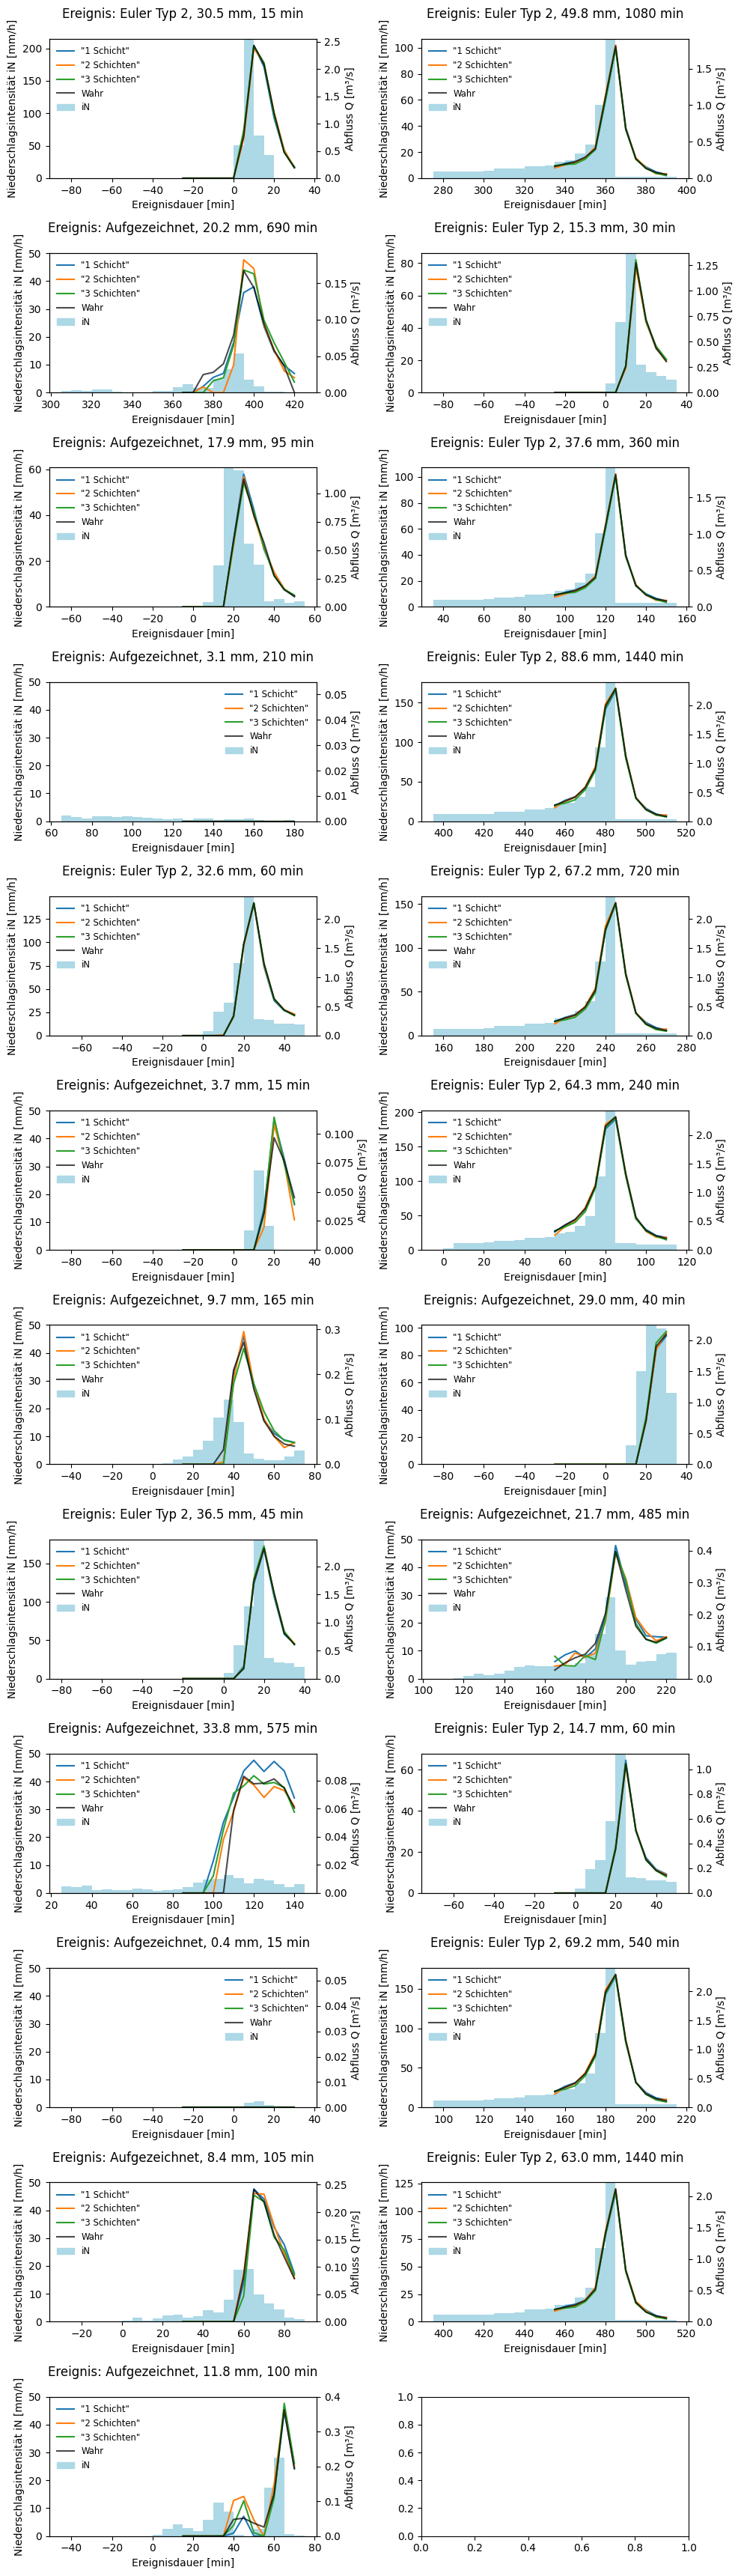

In [23]:
# Plot predict and plot the peak time steps of each event and calculate the peak metrics
#retrieve the interval of the time steps
interval = models[0]['seq_test'][0][0]['interval']
# set peak horizon = time difference between the peak and the start of the prediction
peak_horizon = 30 # in minutes

peak_horizon_steps = int(peak_horizon / interval)
# Create a grid of subplots

abs_errors = [np.array([]) for _ in range(len(models))]
sqrt_errors = abs_errors.copy()
abs_prct_errors = abs_errors.copy()

abs_errors_T = abs_errors.copy()
sqrt_errors_T = abs_errors.copy()
abs_prct_errors_T = abs_errors.copy()
abs_dT = abs_errors.copy()

def add_dur(seq , event_id, n):
    start_time = max(seq_test[event_id][1][n][:, 0]) + interval + delay * interval
    end_time = start_time + p_steps * interval
    # Calculate the start and end time of the sequence so that a duration column can be created
    duration_col = np.arange(start_time, end_time, interval)

    actual_seq = np.column_stack((duration_col,seq))
    return actual_seq, duration_col, start_time, end_time

event_dicts = []
# Loop through n_sample
for event_id in range(len(seq_test_trans)):
    

    dict = {}
    # n = sequence index for the sequence containing the peak
    n = np.argmax(seq_test[event_id][2][:, 0, 0])
    n = n - peak_horizon_steps
    n = n.astype(int)
    dict['n'] = n
    actual_seq = seq_test[event_id][2][n]
    dict['actual_seq'], dict['duration_col'], dict['start_time'], dict['end_time'] = add_dur(actual_seq,event_id, n)
    # Dictionary of event meta data
    dict['meta'] = seq_test[event_id][0] #'name': sample_name, 'duration': event_duration, 'total precipitation': precip_sum, 'max intensity': max_intensity, 'interval': intervall, 'Ereignis': type

    i = 0
    for m in models:
        seq_test = m['seq_test']
        seq_test_trans = m['seq_test_trans']
        model = m['model']

        interval = seq_test[event_id][0]['interval']
        meta = seq_test[event_id][0]
        in_seq = seq_test[event_id][1][n]
        out_act = seq_test[event_id][2][n]

        # Predict the sequence
        Predict = model.predict(seq_test_trans[event_id][1], verbose=0)
        Predict_invert = out_scaler.inverse_transform(Predict)

        predict_seq = np.column_stack((dict['duration_col'],Predict_invert[n]))
        dict[m['print_name']] = predict_seq

        # Calculate the peak metrics time dependent
        argmax = np.argmax(dict['actual_seq'][:, 1])
        actual_max = dict['actual_seq'][argmax, 1]
        predict_max = predict_seq[argmax, 1]
        extreme_abs_error = abs(actual_max - predict_max)
        extreme_squared_error = extreme_abs_error**2
        sqrt_errors[i] = np.append(sqrt_errors[i], extreme_squared_error)
        abs_errors[i] = np.append(abs_errors[i], extreme_abs_error)
        epsilon = 0
        ape =extreme_abs_error / (actual_max + epsilon) * 100
        if np.isinf(ape) == False:
            abs_prct_errors[i] = np.append(abs_prct_errors[i], ape)

        # Calculate the peak metrics time independent
        argmax = np.argmax(dict['actual_seq'][:, 1])
        actual_max = dict['actual_seq'][argmax, 1]
        pred_argmax = np.argmax(predict_seq[:, 1])
        predict_max = predict_seq[pred_argmax, 1]
        extreme_abs_error = abs(actual_max - predict_max)
        extreme_squared_error = extreme_abs_error**2
        sqrt_errors_T[i] = np.append(sqrt_errors_T[i], extreme_squared_error)
        abs_errors_T[i] = np.append(abs_errors_T[i], extreme_abs_error)
        epsilon = 0
        ape =extreme_abs_error / (actual_max + epsilon) * 100
        if np.isinf(ape) == False:
            abs_prct_errors_T[i] = np.append(abs_prct_errors_T[i], ape)
        abs_dT[i] = np.append(abs_dT[i],abs(argmax - pred_argmax) * interval)
        i+=1

    event_dicts.append(dict)    

    
peak_maes = []
peak_rmses = []
peak_mapes = []
peak_maes_T = []
peak_rmses_T = []
peak_mapes_T = []
peak_dT = []

for i in range(len(abs_errors)):
    mae = np.mean(abs_errors[i])
    rmse = np.sqrt(np.mean(sqrt_errors[i]))
    ape = abs_prct_errors[i][~np.isnan(abs_prct_errors[i])]
    mape = np.mean(ape)
    peak_maes.append(mae)
    peak_rmses.append(rmse)
    peak_mapes.append(mape)

    mae_T = np.mean(abs_errors_T[i])
    rmse_T = np.sqrt(np.mean(sqrt_errors_T[i]))
    ape_T = abs_prct_errors_T[i][~np.isnan(abs_prct_errors_T[i])]
    mape_T = np.mean(ape_T)
    peak_maes_T.append(mae_T)
    peak_rmses_T.append(rmse_T)
    peak_mapes_T.append(mape_T)
    peak_dT.append(np.mean(abs_dT[i]))

peak_eval = pd.DataFrame({
    'Modell': [models[i]['print_name'] for i in range(len(models))],
    'MAE [-]': peak_maes,
    'RMSE [-]': peak_rmses,
    'MAPE [%]': peak_mapes
})

peak_eval_T = pd.DataFrame({
    'Modell': [models[i]['print_name'] for i in range(len(models))],
    'MAE [-]': peak_maes_T,
    'RMSE [-]': peak_rmses_T,
    'MAPE [%]': peak_mapes_T,
    'dT [min]': peak_dT
})
display(Markdown('**Auswertung der Maximalwertabweichungen**'))
print(tabulate(peak_eval_T, headers='keys', tablefmt='psql', showindex=False))

display(Markdown('<br>**Auswertung der Maximalwertabweichungen zu gleicher Zeit**'))

print(tabulate(peak_eval, headers='keys', tablefmt='psql', showindex=False))

display(Markdown('<br>**Darstellung aller der Maximalwertvorhersagen**'))

plot_rows = int(len(seq_test_trans)/2+1)
fig, axs = plt.subplots(plot_rows, 2, figsize=(10, 1.5*len(seq_test_trans)))
# Plot the peaks of the events
for event_id, dict in zip(range(len(seq_test_trans)), event_dicts):


    col_index = event_id % 2
    n = dict['n']
    meta = dict['meta']

    # Create Barplot of Precipitation
    ax1 = axs[event_id // 2, col_index]
    ax1.set_title(f"Ereignis: {meta['event type']}, {round(meta['total precipitation'],1)} mm, {meta['duration']} min", pad=20)
    x = seq_test[event_id][1][n][:,0]  # Set x-axis values
    ax1.bar(x, seq_test[event_id][1][n][:,1], color='lightblue', label='iN', width=interval, align='edge')
    top_lim = max(max(seq_test[event_id][1][n][:,1]), 50)
    ax1.set_ylim(bottom=0, top=top_lim)  # Set y-axis to start from zero
    ax1.set_ylabel('Niederschlagsintensität iN [mm/h]')
    ax1.set_xlabel('Ereignisdauer [min]')
    # ax1.legend(fontsize = 'small')
    # Create a twin axis on the right side
    # Plotting the predicted and actual values in the corresponding subplot
    ax2 = ax1.twinx()
    import matplotlib.patches as mpatches
    blue_patch = [mpatches.Patch(color='lightblue', label='iN')]
    for m in models:
        ax2.plot(dict[m['print_name']][:, 0], dict[m['print_name']][:, 1], label=m['print_name'])
    ax2.plot(dict['actual_seq'][:, 0], dict['actual_seq'][:, 1], color = 'black', label='Wahr', alpha=0.70)
    ax2.set_ylim(bottom=0)  # Set y-axis to start from zero
    ax2.set_ylabel('Abfluss Q [m³/s]')
    plt.legend(fontsize = 'small')
    old_handles, labels = ax2.get_legend_handles_labels()
    plt.legend(handles=old_handles + blue_patch, fontsize = 'small', frameon=False)

plt.tight_layout()
# Show the plot
plt.show()
